In [498]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from typing import List

year = 2020
names = ['Date', 'TempAvg', 'TempMin', 'TempMax', 'Rain', 'Snow', 'WindDir', 'WindSpeed', 'WindSpeedMax', 'Pressure', 'Sunshine']

In [499]:
def analize(df):
  print(df.head())
  print(df.describe())
  print(df.head(10))
  print(df.dtypes)
  print(df.shape)

def cleanup(df):
  print(df.isna().sum())
  
  df.dropna(thresh=int(len(df) * 0.2), axis=1, inplace=True)
  
  print(df.isna().sum())
  print(df.shape)

  # df.drop(['TempMin', 'TempMax'], axis=1, inplace=True)

  # df_NoNaN = df.dropna(how='any')

  # print(df_NoNaN.isna().sum())
  # print(df_NoNaN.shape)

  return df.copy()

def plot_NoNaN(df_NoNaN):
  cityName = df_NoNaN['City'].iloc[0]

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=False)
  fig.suptitle(f'{cityName} - {year}')


  ax1.set_title('Temperature')
  plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
  sns.lineplot(data=df_NoNaN, x='Date', y='TempAvg', label='TempAvg', ax=ax1)
  sns.lineplot(data=df_NoNaN, x='Date', y='TempMin', label='TempMin', ax=ax1)
  sns.lineplot(data=df_NoNaN, x='Date', y='TempMax', label='TempMax', ax=ax1)

  if 'Pressure' in df_NoNaN:
    ax2.set_title('Pressure')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    sns.lineplot(data=df_NoNaN, x='Date', y='Pressure', ax=ax2)
  else:
    print('No Pressure data')
  
  if 'WindSpeed' in df_NoNaN or 'WindSpeedMax' in df_NoNaN:
    ax3.set_title('Wind Speed')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))

    if 'WindSpeed' in df_NoNaN:
      sns.lineplot(data=df_NoNaN, x='Date', y='WindSpeed', label='Wind Speed', ax=ax3)
    
    if 'WindSpeedMax' in df_NoNaN:
      sns.lineplot(data=df_NoNaN, x='Date', y='WindSpeedMax', label='Max Wind Speed', ax=ax3)
  else:
    print('No Wind Speed data')

  if 'Rain' in df_NoNaN:
    ax4.set_title('Rain')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    sns.lineplot(data=df_NoNaN, x='Date', y='Rain', ax=ax4)
  else:
    print('No Rain data')
    
  plt.show()


def lagrange_interpolation_manual(x_points, y_points, x):
    """Calculate Lagrange interpolation for xi using given x and y values."""
    n = len(x_points)
    result = 0
    for i in range(n):
        xi, yi = x_points[i], y_points[i]
        p = 1
        for j in range(n):
            xj = x_points[j]
            if i != j:
                p *= (x - xj) / (xi - xj)
        result += p * yi
    return result

def interpolate_column(series):
    """Interpolate missing values in a Pandas Series using Lagrange interpolation."""
    n = len(series)
    
    for idx in range(n):
        if pd.isna(series[idx]):
            left_idx, right_idx = idx - 1, idx + 1
            left_points, right_points = [], []
            
            # Find the nearest two non-NaN points on the left
            while len(left_points) < 2 and left_idx >= 0:
                if not pd.isna(series[left_idx]):
                    left_points.insert(0, (left_idx, series[left_idx]))
                left_idx -= 1
            
            # Find the nearest two non-NaN points on the right
            while len(right_points) < 2 and right_idx < n:
                if not pd.isna(series[right_idx]):
                    right_points.append((right_idx, series[right_idx]))
                right_idx += 1
            
            if len(left_points) + len(right_points) >= 2:
                x, y = zip(*left_points + right_points)
                print("Interpolate for index", idx, "using points", x, y)
                series.iat[idx] = lagrange_interpolation_manual(x, y, idx)
    
    return series

def interpolate_dataframe(df):
    for column in df.columns:
        if is_numeric_dtype(df[column]):
            df[column] = interpolate_column(df[column])
    return df

def introduce_random_nans(df, nan_fraction=0.05):
    """Introduce random NaNs into the DataFrame, avoiding the first two and last two rows."""
    nan_count = int(np.floor(nan_fraction * df.size))
    rows, cols = df.shape
    
    avoid_indices = list(range(2 * cols)) + list(range((rows - 2) * cols, rows * cols))
    
    all_indices = np.arange(df.size)
    available_indices = np.setdiff1d(all_indices, avoid_indices)
    nan_indices = np.random.choice(available_indices, nan_count, replace=False)
    
    flat_df = df.values.flatten()
    flat_df[nan_indices] = np.nan
    
    df_with_nans = pd.DataFrame(flat_df.reshape(df.shape), columns=df.columns)
    df_with_nans = df_with_nans.astype(df.dtypes)
    
    return df_with_nans, nan_indices

def calculate_interpolation_error(original_df, interpolated_df, nan_indices):
    # Flatten the original and interpolated DataFrames
    original_flat = original_df.values.flatten()
    interpolated_flat = interpolated_df.values.flatten()
    
    # Create an empty DataFrame to store the errors
    error_df = pd.DataFrame(index=range(len(nan_indices)), columns=['Error'])
    
    # Calculate the absolute errors at the positions where NaNs were introduced
    for i, idx in enumerate(nan_indices):
        original_value = original_flat[idx]
        interpolated_value = interpolated_flat[idx]
        
        if isinstance(original_value, (int, float)) and not pd.isna(original_value) and \
           isinstance(interpolated_value, (int, float)) and not pd.isna(interpolated_value):
            error_df.loc[i, 'Error'] = abs(original_value - interpolated_value)
    
    return error_df

def plot_interpolation_error(error_df):
    if error_df.empty:
        print("No interpolation errors to plot.")
        return
    
    print("Interpolation error statistics:")
    print(error_df.describe())

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=error_df)
    plt.title('Interpolation Error Distribution')
    plt.ylabel('Absolute Error')
    plt.show()

In [500]:
def read_csv(filename, city_name):
  df = pd.read_csv(filename, delimiter=',', names=names, skiprows=1)  # skipping header row
  df['Date'] = pd.to_datetime(df['Date'])
  df = df[df['Date'].dt.year == year]
  df['City'] = city_name
  return df

In [501]:


# Load the data for multiple cities
df_Krakow = read_csv('Krakow.csv',    'Krakow')
df_Warsaw = read_csv('Warszawa.csv',  'Warszawa')
df_Szczec = read_csv('Szczecin.csv',  'Szczecin')
df_Gdansk = read_csv('Gdansk.csv',    'Gdansk')
df_Podlas = read_csv('Bialystok.csv', 'Bialystok')

city_coords = {
  'Krakow':    (19.94, 50.06),
  'Warszawa':  (21.01, 52.23),
  'Szczecin':  (14.55, 53.43),
  'Gdansk':    (18.65, 54.35),
  'Bialystok': (23.16, 53.13),
}

def run(df):
  df_WithNaN = pd.DataFrame(df)
  analize(df)
  df_NoNaN = cleanup(df)
  plot_NoNaN(df_NoNaN)
  df_with_nans, nan_indices = introduce_random_nans(df_NoNaN.copy(), nan_fraction=0.05)
  print(df_with_nans.dtypes)
  print("DATA:")
  print(df_with_nans.head(100))
  df_interpolated = interpolate_dataframe(df_with_nans.copy())
  print("INTERPOLATED:")
  print(df_interpolated.head(100))
  error_df = calculate_interpolation_error(df_NoNaN.copy(), df_interpolated.copy(), nan_indices)
  print("ERROR:")
  print(error_df.head(100))
  plot_interpolation_error(error_df)
  plot_NoNaN(df_interpolated)
  # plot(df, df_NoNaN, df_WithNaN)


            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
16699 2020-01-01      1.8     -0.8      4.9   0.0   NaN    232.0       16.2   
16700 2020-01-02     -0.8     -4.0      5.3   0.0   NaN    216.0        7.4   
16701 2020-01-03     -0.7     -6.7      5.7   0.0   NaN    208.0        8.7   
16702 2020-01-04      3.7     -0.2      6.1   1.0   NaN    236.0       26.4   
16703 2020-01-05      0.4     -2.8      2.1   2.8  10.0    273.0       18.9   

       WindSpeedMax  Pressure  Sunshine    City  
16699          37.0    1032.9       NaN  Krakow  
16700          22.2    1030.9       NaN  Krakow  
16701          27.8    1024.3       NaN  Krakow  
16702          50.0    1018.5       NaN  Krakow  
16703          44.5    1028.9       NaN  Krakow  
                      Date     TempAvg     TempMin     TempMax        Rain  \
count                  366  366.000000  366.000000  366.000000  359.000000   
mean   2020-07-01 12:00:00    9.864208    5.080055   15.093716    1.8

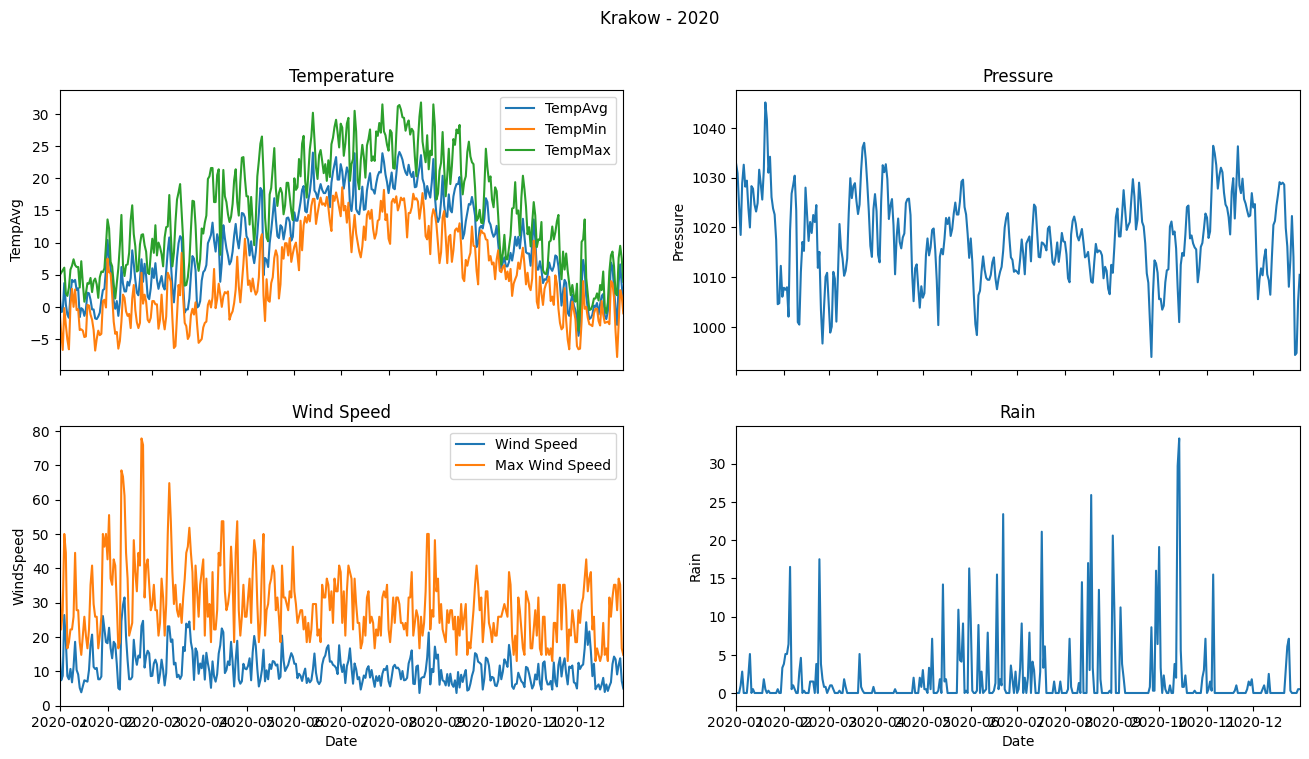

Date            datetime64[ns]
TempAvg                float64
TempMin                float64
TempMax                float64
Rain                   float64
WindDir                float64
WindSpeed              float64
WindSpeedMax           float64
Pressure               float64
City                    object
dtype: object
DATA:
         Date  TempAvg  TempMin  TempMax  Rain  WindDir  WindSpeed  \
0  2020-01-01      1.8     -0.8      4.9   0.0    232.0       16.2   
1  2020-01-02     -0.8     -4.0      5.3   0.0    216.0        7.4   
2  2020-01-03     -0.7     -6.7      5.7   0.0    208.0        8.7   
3  2020-01-04      3.7     -0.2      6.1   1.0    236.0       26.4   
4  2020-01-05      0.4     -2.8      2.1   NaN    273.0       18.9   
..        ...      ...      ...      ...   ...      ...        ...   
95 2020-04-05      6.5     -2.3     14.2   0.0     39.0        NaN   
96 2020-04-06      9.9      0.3     19.9   0.0     34.0       12.3   
97 2020-04-07     10.5      1.0     20.3

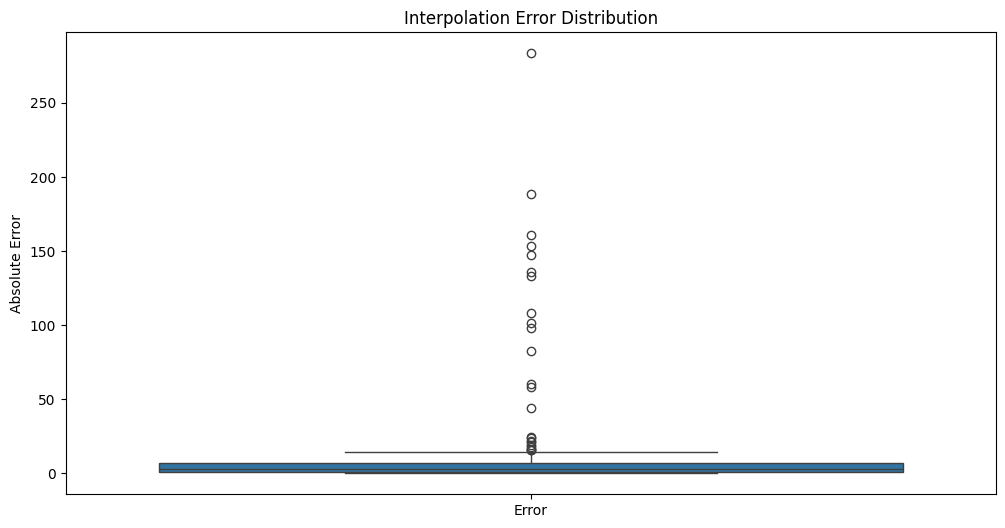

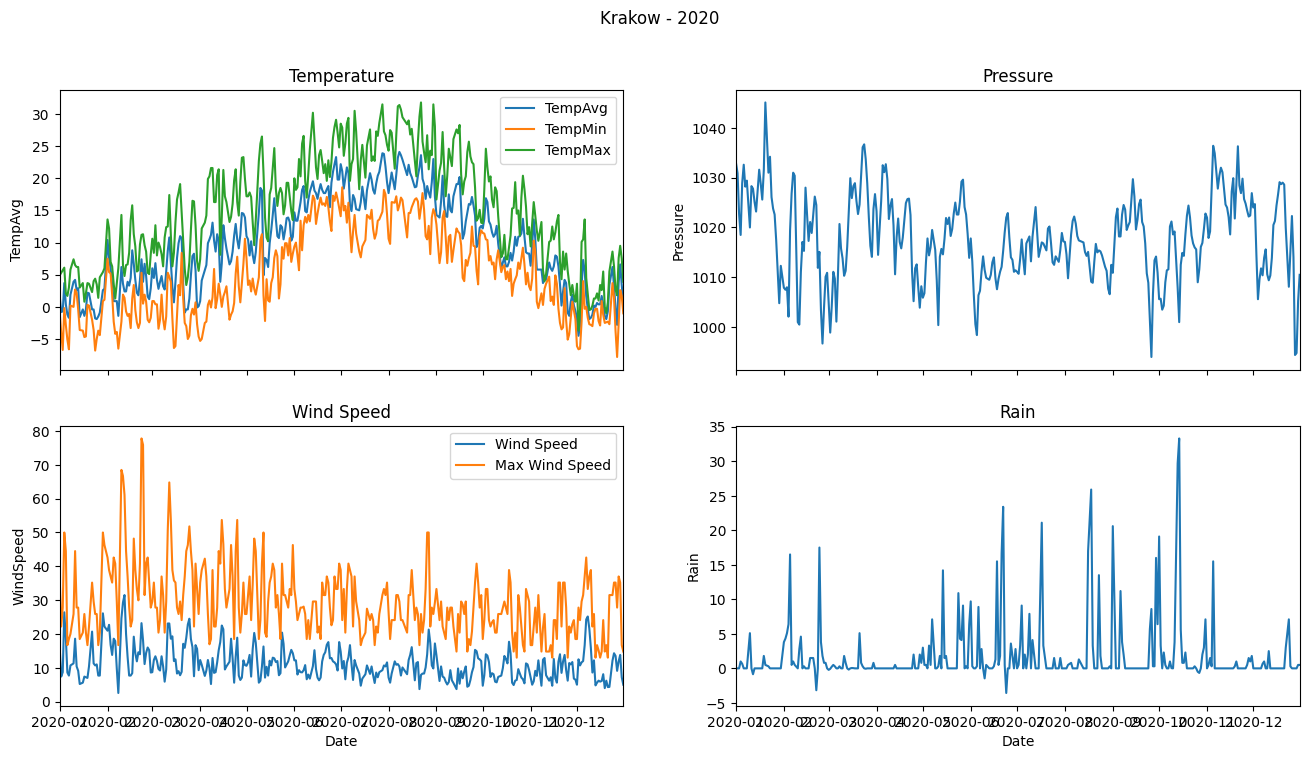

In [502]:
run(df_Krakow)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
21170 2020-01-01      1.4      0.8      5.6   1.0   NaN    267.0       17.4   
21171 2020-01-02      0.8     -1.7      3.1   0.0   NaN    261.0       13.8   
21172 2020-01-03      0.5     -4.1      4.6   0.0   NaN    204.0        6.4   
21173 2020-01-04      3.7      1.6      5.3   1.0   NaN    258.0       20.7   
21174 2020-01-05      0.4     -2.4      2.3   1.8   NaN    283.0       17.9   

       WindSpeedMax  Pressure  Sunshine      City  
21170          37.0    1029.3       NaN  Warszawa  
21171          35.2    1026.5       NaN  Warszawa  
21172          24.1    1020.1       NaN  Warszawa  
21173          44.5    1012.3       NaN  Warszawa  
21174          42.6    1025.8       NaN  Warszawa  
                      Date     TempAvg     TempMin     TempMax        Rain  \
count                  366  366.000000  366.000000  366.000000  342.000000   
mean   2020-07-01 12:00:00   10.621585    6.276230   14.7

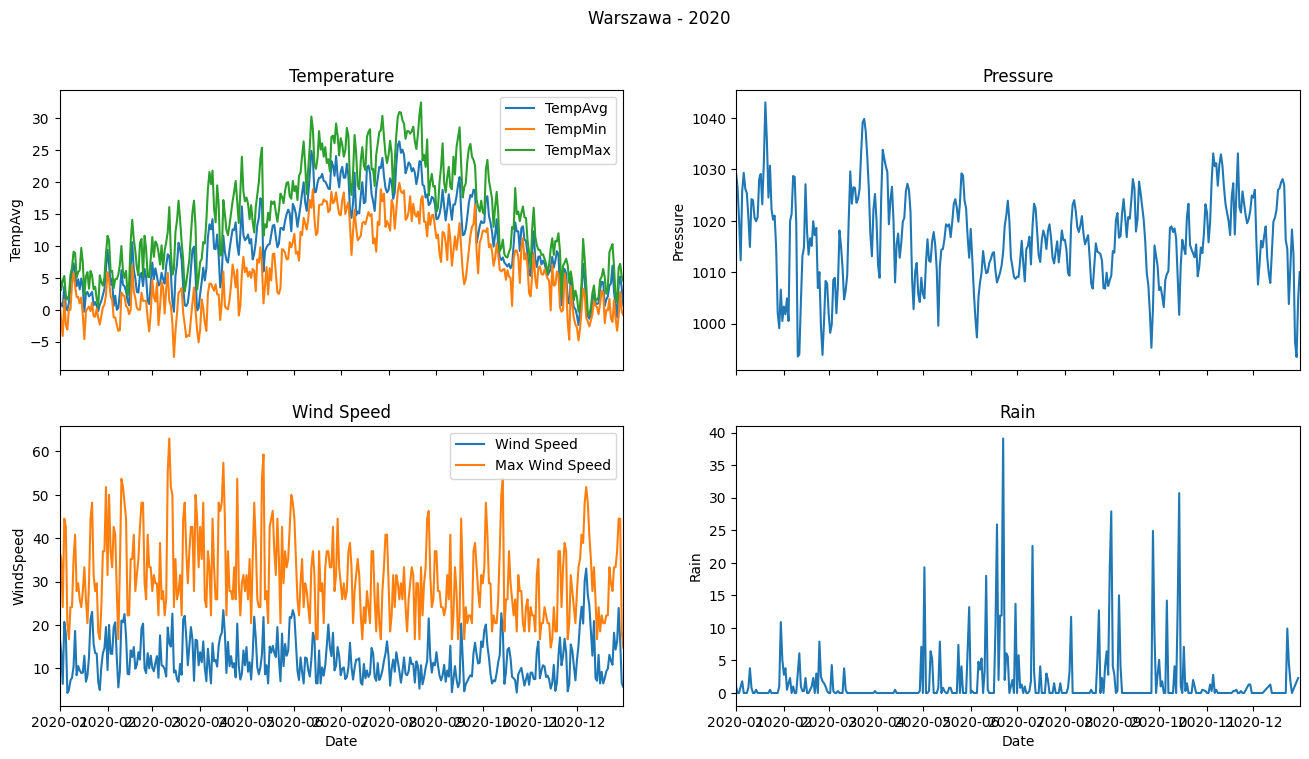

Date            datetime64[ns]
TempAvg                float64
TempMin                float64
TempMax                float64
Rain                   float64
WindDir                float64
WindSpeed              float64
WindSpeedMax           float64
Pressure               float64
City                    object
dtype: object
DATA:
         Date  TempAvg  TempMin  TempMax  Rain  WindDir  WindSpeed  \
0  2020-01-01      1.4      0.8      5.6   1.0    267.0       17.4   
1  2020-01-02      0.8     -1.7      3.1   0.0    261.0       13.8   
2  2020-01-03      0.5     -4.1      4.6   0.0    204.0        6.4   
3  2020-01-04      3.7      1.6      5.3   1.0    258.0       20.7   
4  2020-01-05      0.4     -2.4      2.3   1.8    283.0       17.9   
..        ...      ...      ...      ...   ...      ...        ...   
95        NaT      6.5     -3.3     14.0   0.0     90.0        7.0   
96 2020-04-06     11.3      2.5     18.9   0.0    122.0       14.5   
97 2020-04-07     13.4      4.1     21.6

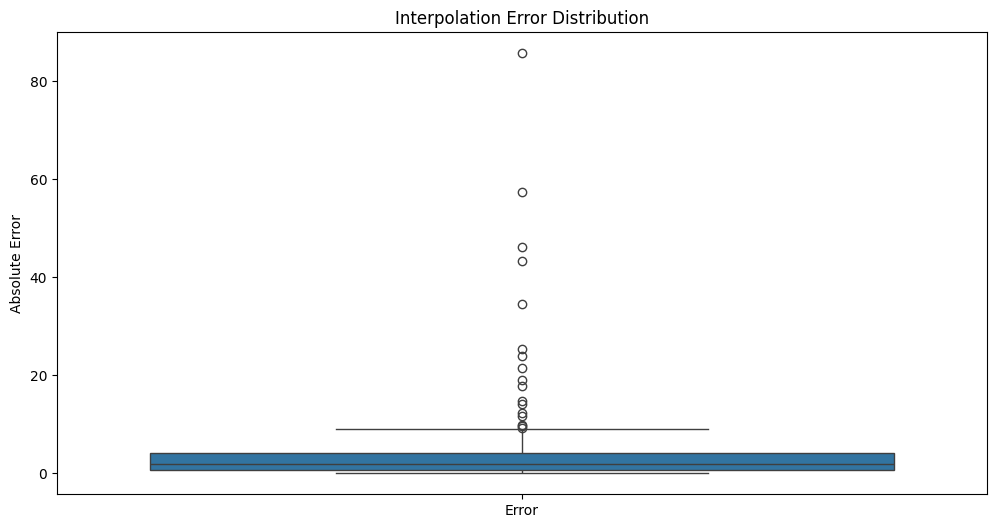

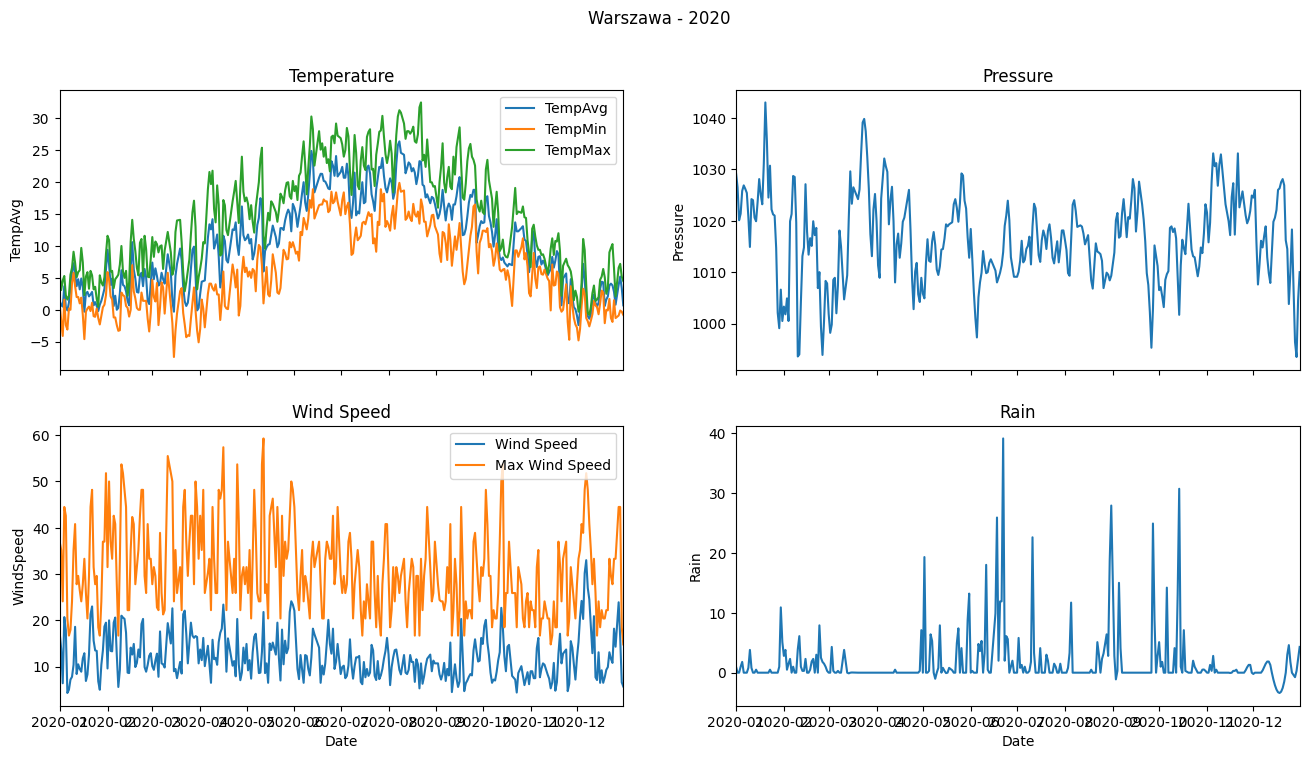

In [503]:
run(df_Warsaw)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
24968 2020-01-01      1.2     -2.0      4.2   0.0   NaN    239.0       11.1   
24969 2020-01-02     -0.4     -3.0      4.8   0.0   NaN    194.0        9.9   
24970 2020-01-03      3.3     -0.4      6.0   0.0   NaN    207.0       15.6   
24971 2020-01-04      3.5      2.0      6.4   2.3   NaN    269.0       22.2   
24972 2020-01-05      0.6     -2.0      4.0   1.8   NaN    239.0       10.3   

       WindSpeedMax  Pressure  Sunshine      City  
24968          25.9    1030.8       NaN  Szczecin  
24969          29.6    1025.0       NaN  Szczecin  
24970          40.8    1015.2       NaN  Szczecin  
24971          48.2    1015.0       NaN  Szczecin  
24972          35.2    1030.0       NaN  Szczecin  
                      Date     TempAvg     TempMin     TempMax        Rain  \
count                  366  366.000000  366.000000  366.000000  347.000000   
mean   2020-07-01 12:00:00   10.251093    5.714754   15.0

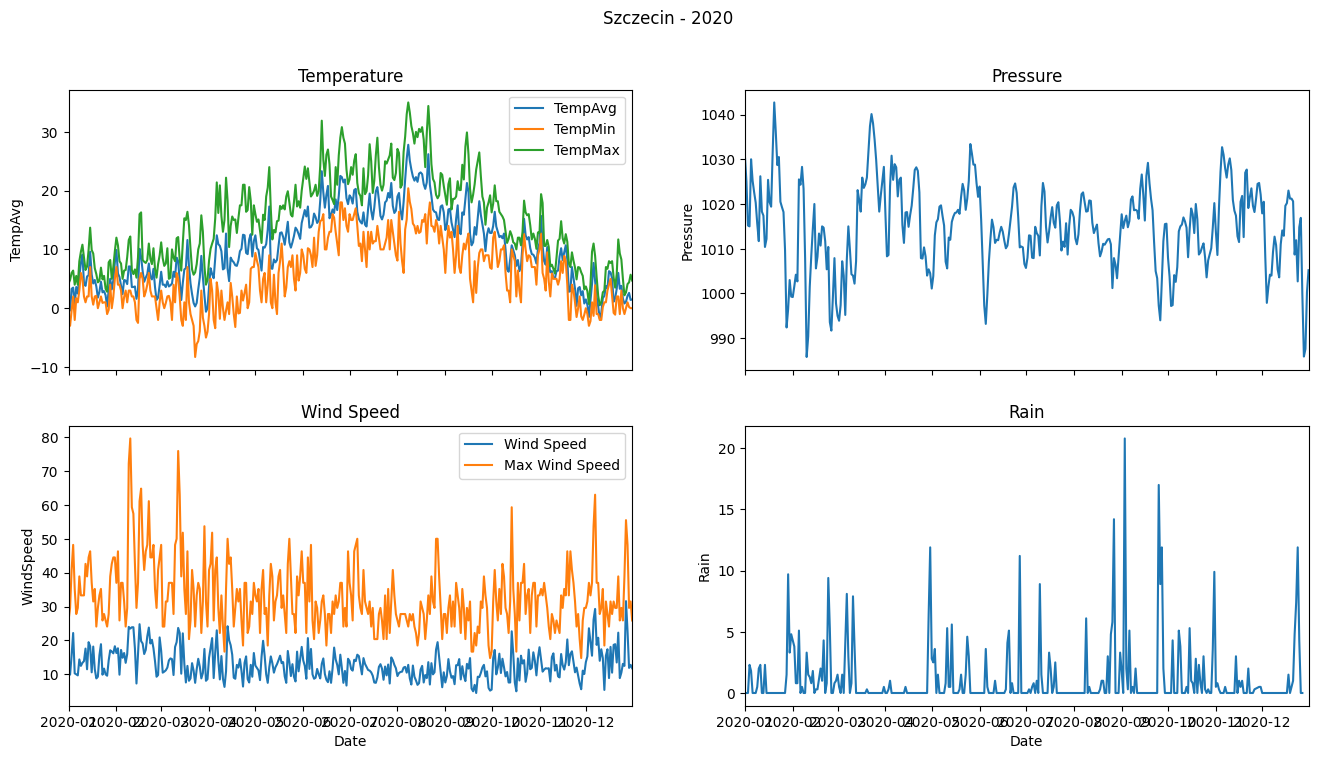

Date            datetime64[ns]
TempAvg                float64
TempMin                float64
TempMax                float64
Rain                   float64
WindDir                float64
WindSpeed              float64
WindSpeedMax           float64
Pressure               float64
City                    object
dtype: object
DATA:
         Date  TempAvg  TempMin  TempMax  Rain  WindDir  WindSpeed  \
0  2020-01-01      1.2     -2.0      4.2   0.0    239.0       11.1   
1  2020-01-02     -0.4     -3.0      4.8   0.0    194.0        9.9   
2  2020-01-03      3.3     -0.4      6.0   0.0    207.0       15.6   
3  2020-01-04      3.5      2.0      NaN   2.3    269.0       22.2   
4  2020-01-05      NaN     -2.0      4.0   1.8    239.0       10.3   
..        ...      ...      ...      ...   ...      ...        ...   
95 2020-04-05      8.5     -3.4     15.3   0.0    129.0       16.4   
96 2020-04-06     12.4      4.4     21.4   0.0    131.0       23.0   
97 2020-04-07     10.9      2.5     16.2

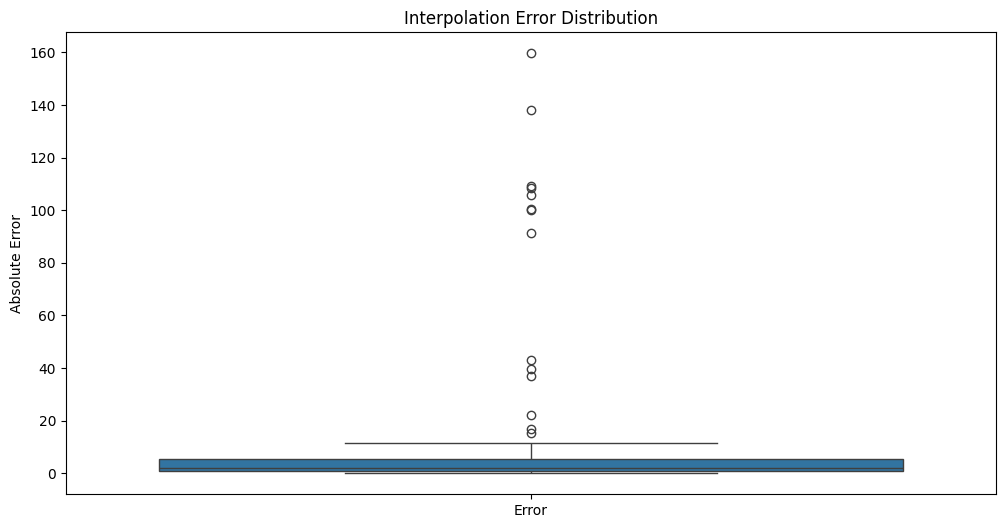

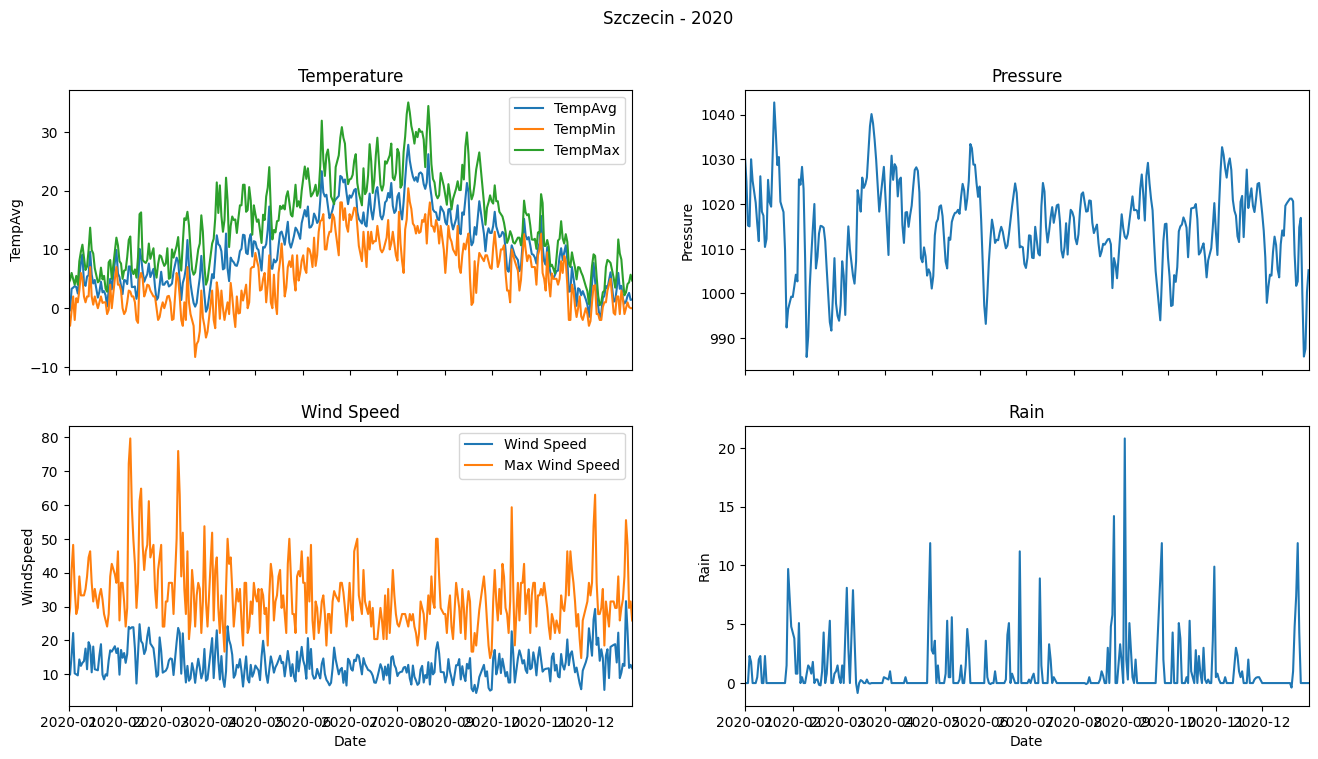

In [504]:
run(df_Szczec)

           Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
9713 2020-01-01      2.4      0.0      5.0   NaN   NaN    273.0       29.1   
9714 2020-01-02      2.4      0.0      5.0   NaN   NaN    251.0       15.9   
9715 2020-01-03      2.3     -1.0      4.0   NaN   NaN    239.0       22.1   
9716 2020-01-04      2.3      0.0      4.0   NaN   NaN    277.0       30.1   
9717 2020-01-05      0.3     -1.0      2.0   NaN   NaN    281.0       16.0   

      WindSpeedMax  Pressure  Sunshine    City  
9713          44.5    1024.9       NaN  Gdansk  
9714          44.5    1021.0       NaN  Gdansk  
9715          42.6    1012.9       NaN  Gdansk  
9716          59.3    1008.0       NaN  Gdansk  
9717          40.8    1025.8       NaN  Gdansk  
                      Date     TempAvg     TempMin     TempMax  Rain  Snow  \
count                  366  366.000000  366.000000  366.000000   0.0   0.0   
mean   2020-07-01 12:00:00    9.278415    5.740437   12.797814   NaN   NaN   
min

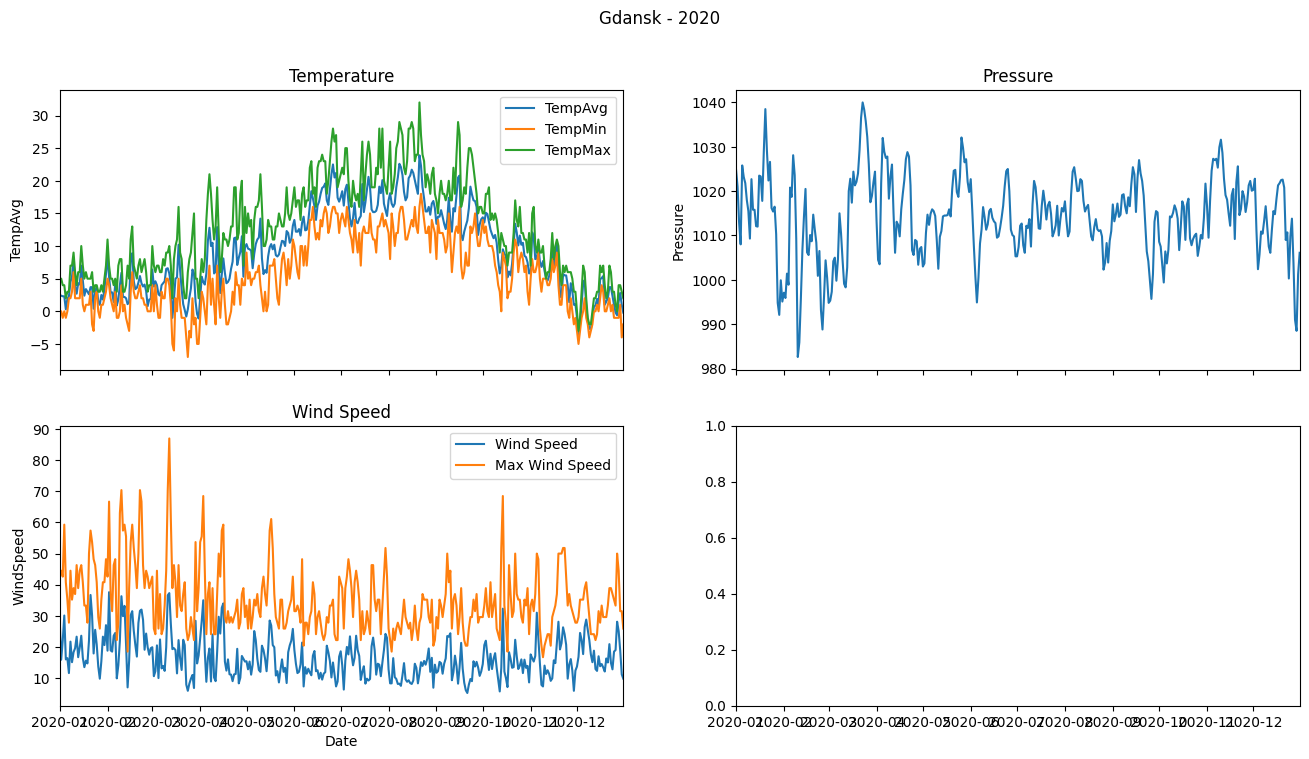

Date            datetime64[ns]
TempAvg                float64
TempMin                float64
TempMax                float64
WindDir                float64
WindSpeed              float64
WindSpeedMax           float64
Pressure               float64
City                    object
dtype: object
DATA:
         Date  TempAvg  TempMin  TempMax  WindDir  WindSpeed  WindSpeedMax  \
0  2020-01-01      2.4      0.0      5.0    273.0       29.1          44.5   
1  2020-01-02      2.4      0.0      5.0    251.0       15.9          44.5   
2  2020-01-03      2.3     -1.0      4.0    239.0       22.1          42.6   
3  2020-01-04      2.3      0.0      4.0    277.0       30.1          59.3   
4  2020-01-05      0.3     -1.0      2.0    281.0       16.0          40.8   
..        ...      ...      ...      ...      ...        ...           ...   
95 2020-04-05      5.8     -2.0     14.0    226.0        8.8          24.1   
96 2020-04-06     10.8      4.0     18.0    155.0       16.5          37.0   

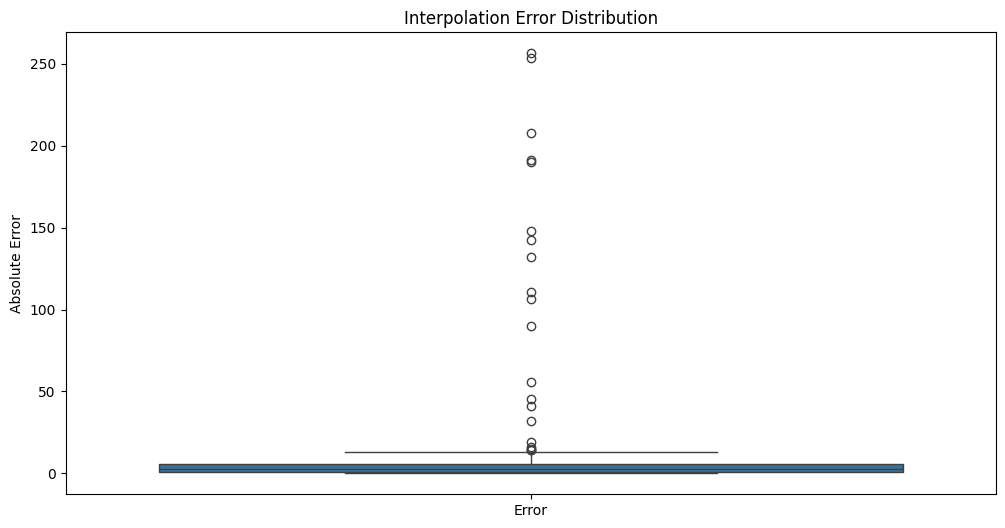

No Rain data


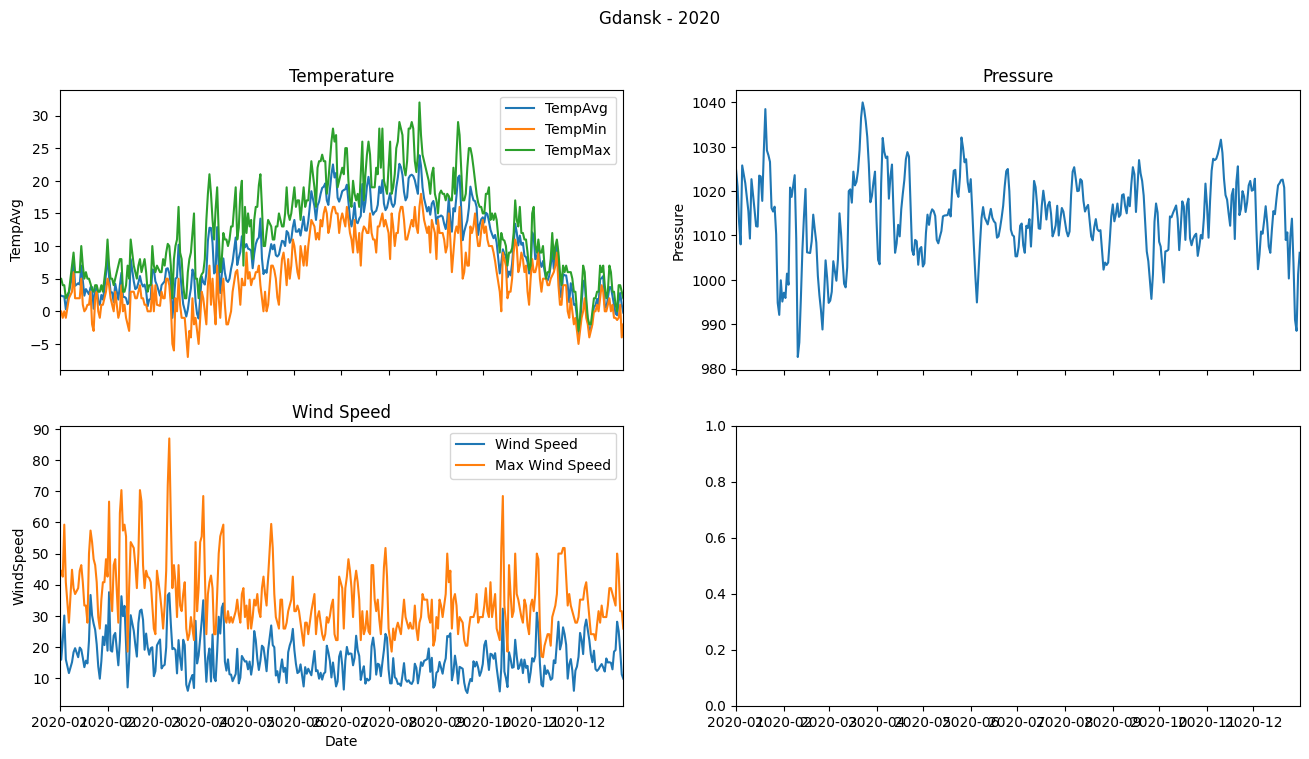

In [505]:
run(df_Gdansk)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
21070 2020-01-01      1.3      0.6      4.2   3.3   NaN    271.0       10.7   
21071 2020-01-02      0.4     -1.3      2.5   0.0   NaN    252.0       10.5   
21072 2020-01-03     -0.2     -3.4      2.2   0.0   NaN    232.0        8.6   
21073 2020-01-04      2.5      0.2      4.0   2.0   NaN    254.0       14.0   
21074 2020-01-05     -0.6     -2.8      3.0   2.8  30.0    299.0        9.3   

       WindSpeedMax  Pressure  Sunshine       City  
21070          31.5    1025.8       NaN  Bialystok  
21071          27.8    1023.6       NaN  Bialystok  
21072          25.9    1018.4       NaN  Bialystok  
21073          38.9    1008.7       NaN  Bialystok  
21074          27.8    1022.6       NaN  Bialystok  
                      Date     TempAvg     TempMin     TempMax        Rain  \
count                  366  366.000000  366.000000  366.000000  358.000000   
mean   2020-07-01 12:00:00    9.207923    4.651366 

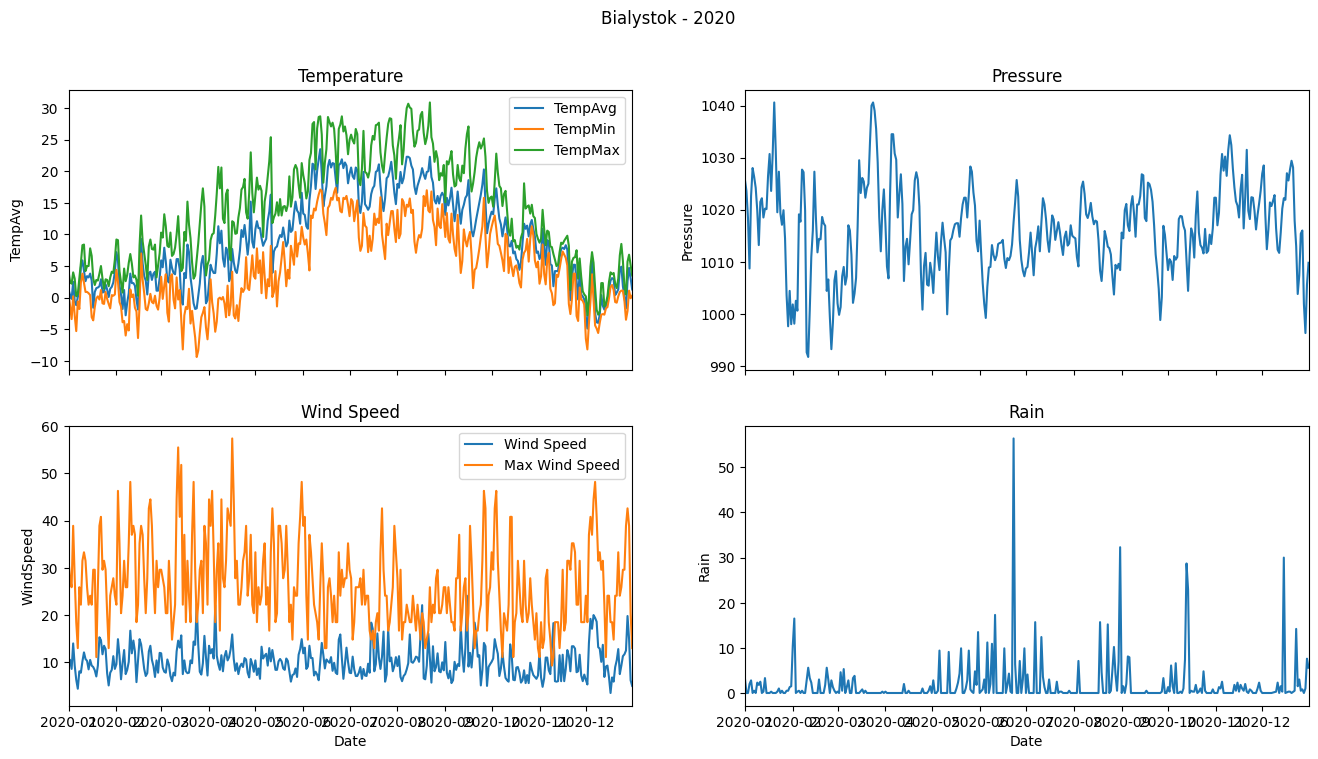

Date            datetime64[ns]
TempAvg                float64
TempMin                float64
TempMax                float64
Rain                   float64
WindDir                float64
WindSpeed              float64
WindSpeedMax           float64
Pressure               float64
City                    object
dtype: object
DATA:
         Date  TempAvg  TempMin  TempMax  Rain  WindDir  WindSpeed  \
0  2020-01-01      1.3      0.6      4.2   3.3    271.0       10.7   
1  2020-01-02      0.4     -1.3      2.5   0.0    252.0       10.5   
2  2020-01-03     -0.2     -3.4      2.2   0.0    232.0        8.6   
3  2020-01-04      2.5      0.2      4.0   2.0    254.0       14.0   
4  2020-01-05     -0.6     -2.8      3.0   2.8    299.0        9.3   
..        ...      ...      ...      ...   ...      ...        ...   
95 2020-04-05      3.9     -5.4     13.0   0.0      NaN       22.1   
96 2020-04-06      7.0     -3.8     16.5   0.0    139.0       11.4   
97 2020-04-07     11.3     -0.2     20.7

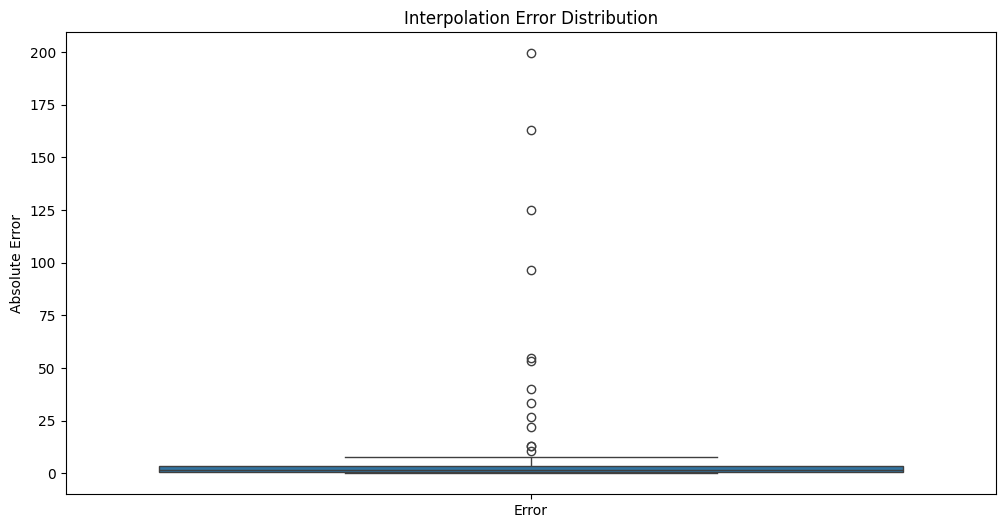

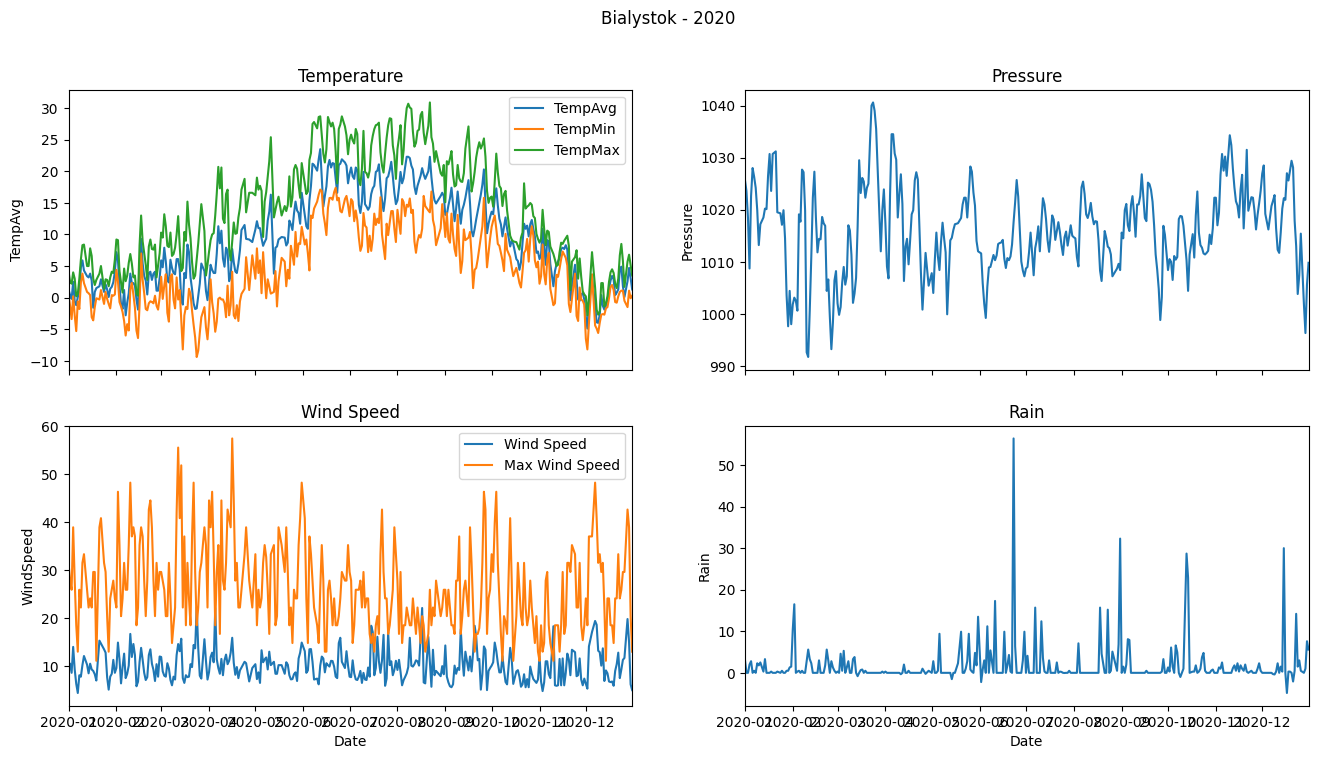

In [506]:
run(df_Podlas)

In [507]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from ipywidgets import interact, widgets

# Concatenate all data into a single DataFrame
data = pd.concat([df_Krakow, df_Warsaw, df_Szczec, df_Gdansk, df_Podlas])

data['lon'] = data['City'].map(lambda city: city_coords[city][0])
data['lat'] = data['City'].map(lambda city: city_coords[city][1])

# Function to create a map for the selected date
def plot_temperature(date):
    df = data[data['Date'] == pd.Timestamp(date)]
    
    if df.empty:
        print(f"No data available for {date}")
        return
    
    # Generate a grid for interpolation
    grid_lon, grid_lat = np.mgrid[14:25:10j, 49:55:10j]
    
    # Interpolate the data onto the grid
    grid_temp = griddata((df['lon'], df['lat']), df['TempAvg'], (grid_lon, grid_lat), method='cubic', rescale=True)
    
    # Create the map
    plt.figure(figsize=(12, 6))

    proj = ccrs.PlateCarree() # LambertAzimuthalEqualArea()


    ax = plt.axes(projection=proj)
    ax.set_extent([14, 25, 49, 55], crs=proj)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    # Plot contours with fixed color bar limits and gradient colors
    contour = ax.contourf(grid_lon, grid_lat, grid_temp, 60, transform=proj, cmap='coolwarm')
    plt.colorbar(contour, ax=ax, orientation='vertical', label='Temperature (°C)')
    
    for cityName in city_coords.keys():
        ax.text(city_coords[cityName][0], city_coords[cityName][1], cityName, transform=proj, fontsize=12, verticalalignment='center', color='black', zorder=6)
    
    
    # Add title
    plt.title(f'Temperature Distribution in Poland on {date}')
    
    # Display the map
    plt.show()

# Create a date slider widget
date_slider = widgets.SelectionSlider(
    options=[date.strftime('%Y-%m-%d') for date in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')],
    description='Date',
    continuous_update=False
)

# Connect the widget to the function
interact(plot_temperature, date=date_slider)

# plot_temperature(f'{year}-01-01')


interactive(children=(SelectionSlider(continuous_update=False, description='Date', options=('2020-01-01', '202…

<function __main__.plot_temperature(date)>